In [1]:
import os
import lib
import nibabel
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use('ggplot')
DATA_DIR = os.path.join(lib.basic.DATA_DIR(), 'myelin_grad')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
## Define ROI information
maps = {}
regions = ['cb', 'cc']
ROI = lib.roi.VolumeAtlas()

## Load mask for cerebellum
CB_INDICES = ROI.get_idx(ROI.get_roi_id('CEREBELLUM'))
CB_MASK = nibabel.load(os.path.join(DATA_DIR, 'cb_mask.nii.gz')).get_fdata()[CB_INDICES]
CB_INCLUDED = np.where(CB_MASK == 1)

In [ ]:
# Generate myelination maps, and write output to pickle files
# Skip it if myelination maps already exist
maps['cb'] = lib.myelin.get_maps_of_all_subs(
    lib.myelin.get_vol_map_from_file, show_progress=True, subset=CB_INCLUDED,
    map_kargs={'subset': CB_INDICES, 'fname_template': 'temp/Smoothed_{sub_id}_myelin_map.nii.gz'}
)
maps['cb'].to_pickle(os.path.join(DATA_DIR, f'cb_maps.pickle'))

maps['cc'] = lib.myelin.get_maps_of_all_subs(lib.myelin.get_cc_map, show_progress=True)
maps['cc'].to_pickle(os.path.join(DATA_DIR, f'cc_maps.pickle'))

In [5]:
# Load myelination maps
maps = {region: pd.read_pickle(os.path.join(DATA_DIR, f'{region}_maps.pickle')) for region in regions}

# Gradient analysis
basic_grad_results, pca_outputs, time_profiles, time_profiles_mean = {}, {}, {}, {}
for region in regions:
    pca_output, grad_pca = lib.grad.basic_grad_pca(maps[region])
    pca_outputs[region] = pca_output
    basic_grad_results[region] = grad_pca
    time_profiles[region] = lib.grad.get_time_profile(basic_grad_results[region])
    time_profiles_mean[region] = np.row_stack(time_profiles[region]['mean'])

n_voxel: 12075
Descriptive result of n_outliers: 
DescribeResult(nobs=652, minmax=(1, 1), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
n_voxel: 59412
Descriptive result of n_outliers: 
DescribeResult(nobs=652, minmax=(1, 1), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


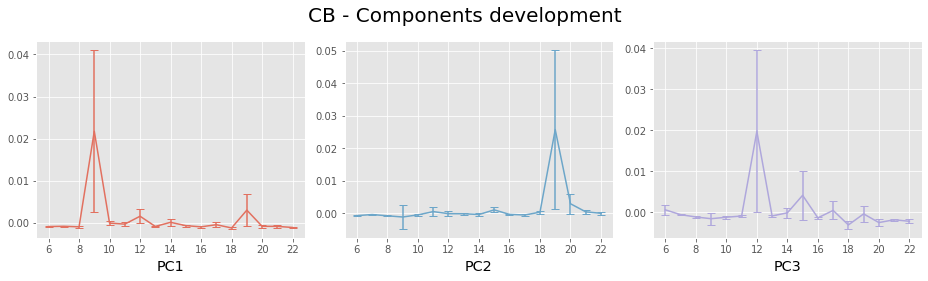

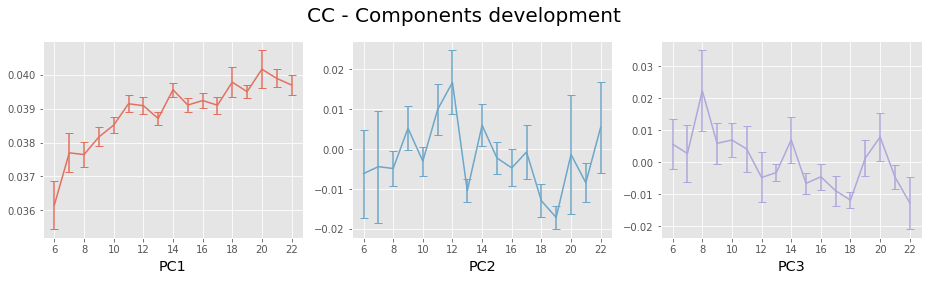

In [6]:
# Plots of development
for region in regions:
    lib.grad.plot_time_profile(time_profiles[region],
        n_comp=3, roi_name=region.upper(), fname=f'figures/myelin_grad/{region}_development.svg'
    )

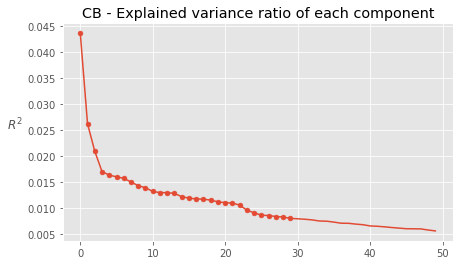

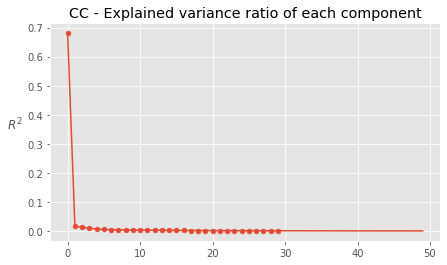

In [7]:
# Plots of explained variance
for region in regions:
    lib.grad.plot_pca_r2(basic_grad_results[region].explained_variance_ratio_, region.upper())

In [ ]:
# Export spatial maps of cerebellum
cb_spatial_maps = lib.grad.get_spatial_map(pca_outputs['cb'], basic_grad_results['cb'], n_comp=3)
for i in range(n_comp):
    spatial_map = np.ones_like(CB_MASK) * np.nan
    spatial_map[CB_INCLUDED] = cb_spatial_maps[i]
    nibabel.save(spatial_map, f'data/myelin_grad/cb-grad-spatial-{i + 1}.nii')